This notebook explores the Medical Cost Personal Dataset through the lenses of both Regression and Classification. The goal is to build a robust system that can not only predict the specific dollar amount of medical insurance charges but also categorize individuals into "cost brackets" with high confidence.

### Content

* #### I. [Data Preparation](#prep)
* #### II. [Probabilistic Regression](#regression)
* #### III. [Ensemble Methods](#ensemble)
* #### IV. [Discretization Strategy](#discrete)
* #### V. [Probability & Overfitting](#probs)
* #### VI. [GridSearchCV Optimization](#opt) | 
* #### VII. [Metric Bridging](#metrics)

<a id="prep"></a>
### Data Preparation & Preprocessing

First of all, let's import all necessary libraries:

In [1012]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, make_scorer, accuracy_score, \
                            precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, StackingRegressor, \
                             RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

Let's load dataset ans see some stats:

In [907]:
data = pd.read_csv("./data/insurance.csv")

data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [908]:
data.shape

(1338, 7)

In [909]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [910]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [911]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Data seems to be clean. Let's split data into train and test, and transform it:

In [912]:
X = data.drop(columns="charges")
y = data["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((1070, 6), (268, 6))

In [913]:
cat_idx = X_train.select_dtypes(include="object").columns
num_idx = X_train.select_dtypes(exclude="object").columns

cat_idx, num_idx

(Index(['sex', 'smoker', 'region'], dtype='object'),
 Index(['age', 'bmi', 'children'], dtype='object'))

In [914]:
[X_train[idx].value_counts() for idx in cat_idx]

[sex
 male      548
 female    522
 Name: count, dtype: int64,
 smoker
 no     850
 yes    220
 Name: count, dtype: int64,
 region
 southeast    283
 northeast    267
 southwest    264
 northwest    256
 Name: count, dtype: int64]

In [915]:
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_idx.tolist()),
    ("cat", OneHotEncoder(drop="first", sparse_output=False), cat_idx.tolist())
])

preprocessor.set_output(transform="pandas")

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Here is an important moment: we need to fit out preprocessor with train data, not test, in order to prevent data leakage.

In [916]:
X_train_transformed.head()

,num__age,num__bmi,num__children,cat__sex_male,cat__smoker_yes,cat__region_northwest,cat__region_southeast,cat__region_southwest
560,0.472227,-1.756525,0.734336,0.0,0.0,1.0,0.0,0.0
1285,0.543313,-1.033082,-0.911192,0.0,0.0,0.0,0.0,0.0
1142,0.898745,-0.943687,-0.911192,0.0,0.0,0.0,1.0,0.0
969,-0.025379,0.622393,3.202629,0.0,0.0,0.0,1.0,0.0
486,1.040918,-1.504893,1.557100,0.0,0.0,1.0,0.0,0.0


In [917]:
X_train_transformed.shape

(1070, 8)

And now, we are ready to go forward

<a id="regression"></a>
### Probabilistic Regression

For now, let's train some models(not ensemble) in the following list:

In [918]:
models = [
    ("Lin.Regr", LinearRegression()),
    ("Lasso", Lasso()),
    ("Ridge", Ridge()),
    ("ElasticNet", ElasticNet()),
    ("Des. Tree Reg.", DecisionTreeRegressor(random_state=42)) 
]

In [919]:
def get_cv_regression_results(models):
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'R2': 'r2',
        'RMSE': 'neg_root_mean_squared_error'
    }

    results = []
    k = 5

    for name, model in models:
        cv_results = cross_validate(
            estimator=model,
            X=X_train_transformed,
            y=y_train,
            cv=k,
            scoring=scoring
        )

        results.append({
            "Model": name,
            "MAE": -cv_results['test_MAE'].mean(),
            "RMSE": -cv_results['test_RMSE'].mean(),
            "R2": cv_results['test_R2'].mean()
        })

    results_df = pd.DataFrame(results).sort_values(by="MAE")

    return results_df

In [920]:
results_df = get_cv_regression_results(models)

In [921]:
def plot_regression_metrics(df, title, mae_palette='viridis_r', r2_palette='magma'):
    sns.set_theme(style="whitegrid")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.barplot(
        data=df.sort_values(by="MAE"), 
        x='MAE', 
        y='Model', 
        hue='Model',       
        legend=False,      
        palette=mae_palette, 
        ax=axes[0]
    )
    axes[0].set_title('Mean Absolute Error', fontsize=12, fontweight='bold', pad=10)
    axes[0].set_xlabel('MAE', fontsize=11)
    axes[0].set_ylabel('Model', fontsize=11)

    sns.barplot(
        data=df.sort_values(by="R2", ascending=False), 
        x='R2', 
        y='Model', 
        hue='Model',       
        legend=False,     
        palette=r2_palette, 
        ax=axes[1]
    )
    axes[1].set_title('R² Score', fontsize=12, fontweight='bold', pad=10)
    axes[1].set_xlabel('R² Score', fontsize=11)
    axes[1].set_ylabel('') 

    fig.suptitle(title, fontsize=18, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()

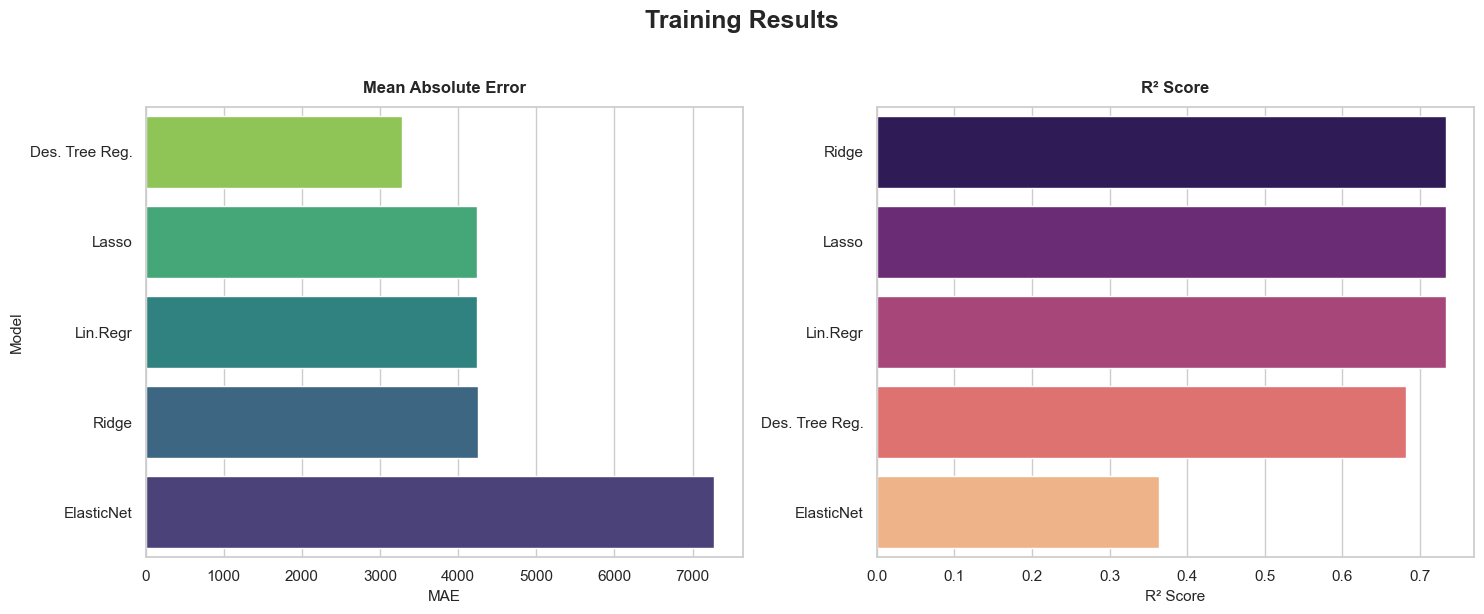

In [922]:
plot_regression_metrics(results_df, title="Training Results")

Above we see results of training

Next, i want to compute confidence intervals for model's predictions. In a standard linear model, we assume the relationship is:
$$y = f(x) + \epsilon$$
Where $\epsilon$ is the "noise" or error. To make this probabilistic, we assume this noise follows a Normal distribution with a mean of zero:
$$\epsilon \sim \mathcal{N}(0, \sigma^2)$$
This means that for any prediction $\hat{y}$, the "true" value $y$ is actually a distribution centered at $\hat{y}$ with a spread defined by $\sigma$.
Since I have already performed Cross-Validation on training set, I have the most robust estimate of $\sigma$. The RMSE (Root Mean Squared Error) is mathematically the best estimate of the standard deviation of the residuals for unseen data.
$$\sigma \approx \text{RMSE}_{CV}$$
I want a 95% Confidence Interval. In a standard Normal distribution ($Z$-distribution):95% of the data falls within approximately 1.96 standard deviations of the mean.This $1.96$ is the Z-score ($Z_{\alpha/2}$) for a 95% two-tailed test.
For every individual prediction $\hat{y}_i$ in test set, I will calculate the upper and lower limits:
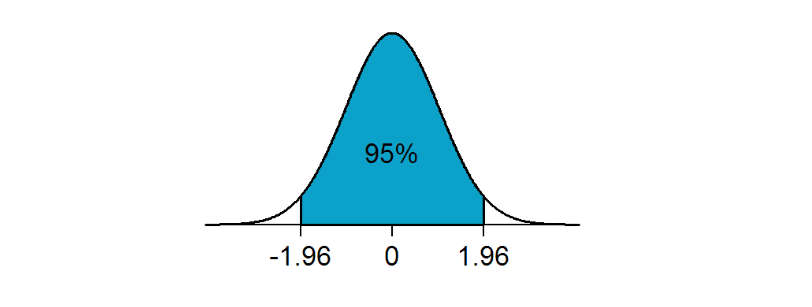
$$Upper\ Bound = \hat{y}_i + (1.96 \cdot \text{RMSE}_{CV})$$
$$Lower\ Bound = \hat{y}_i - (1.96 \cdot \text{RMSE}_{CV})$$

In [923]:
def get_conf_int(y_hat, se, z=1.96):
    return (y_hat + z * se, y_hat - z * se)

In [924]:
trained_models = []

for name, model in models:
    trained_models.append((
        name, model.fit(X_train_transformed, y_train)
    ))

In [925]:
def get_evaluation_results(trained_models, results_df):
    all_predictions = []
    results = []

    for name, model in trained_models:
        y_hat = model.predict(X_test_transformed)
        
        se = results_df[results_df["Model"] == name]["RMSE"].values[0]
        
        ci_plus, ci_minus = get_conf_int(y_hat, se)
        
        df_temp = pd.DataFrame({
            'Actual': y_test.values,
            'Predicted': y_hat,
            'Lower_Bound': np.maximum(0, ci_minus), 
            'Upper_Bound': ci_plus,
            'Model': name,
        })
        all_predictions.append(df_temp)

        results.append({
            "Model": name,
            "RMSE": root_mean_squared_error(y_test, y_hat),
            "R2": r2_score(y_test, y_hat),
            "MAE": mean_absolute_error(y_test, y_hat),
        })

    eval_results_df = pd.DataFrame(results).sort_values(by="MAE")
    final_preds_df = pd.concat(all_predictions, ignore_index=True)

    return eval_results_df, final_preds_df

In [926]:
baseline_eval_results_df, final_preds_df = get_evaluation_results(trained_models, results_df)

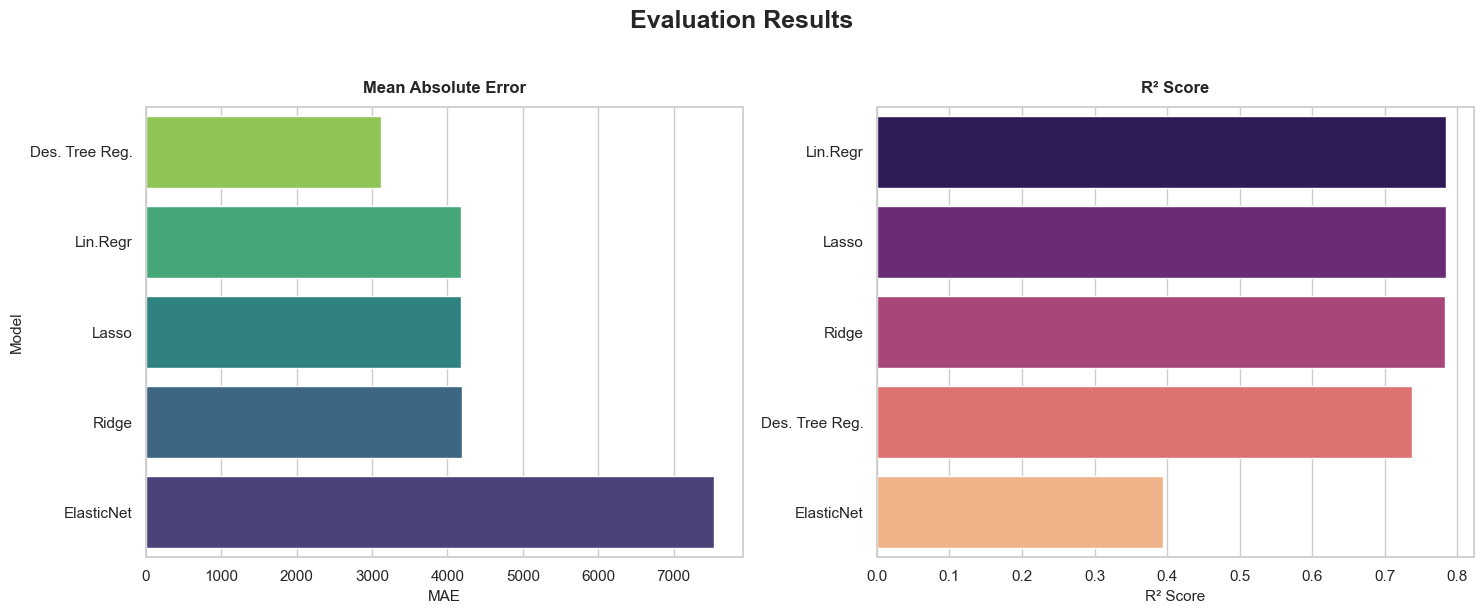

In [927]:
plot_regression_metrics(baseline_eval_results_df, title="Evaluation Results")

In [928]:
def plot_model_intervals(df, models_list, n_samples=50):
    n_models = len(models_list)
    fig, axes = plt.subplots(n_models, 1, figsize=(15, 6 * n_models))
    
    if n_models == 1:
        axes = [axes]

    for i, model_name in enumerate(models_list):
        sample_df = df[df["Model"] == model_name].iloc[:n_samples].reset_index(drop=True)
        ax = axes[i]
        
        ax.fill_between(sample_df.index, 
                        sample_df['Lower_Bound'], 
                        sample_df['Upper_Bound'], 
                        color='gray', alpha=0.2, label='95% Probabilistic Bound')

        ax.plot(sample_df.index, sample_df['Predicted'], 
                label='Prediction', color='blue', linewidth=2, alpha=0.8)

        ax.scatter(sample_df.index, sample_df['Actual'], 
                   label='Actual Value', color='red', s=30, zorder=3)

        ax.set_title(f'95% Confidence Intervals: {model_name}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Test Sample Index')
        ax.set_ylabel('Insurance Charges ($)')
        ax.legend(loc='upper left')
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

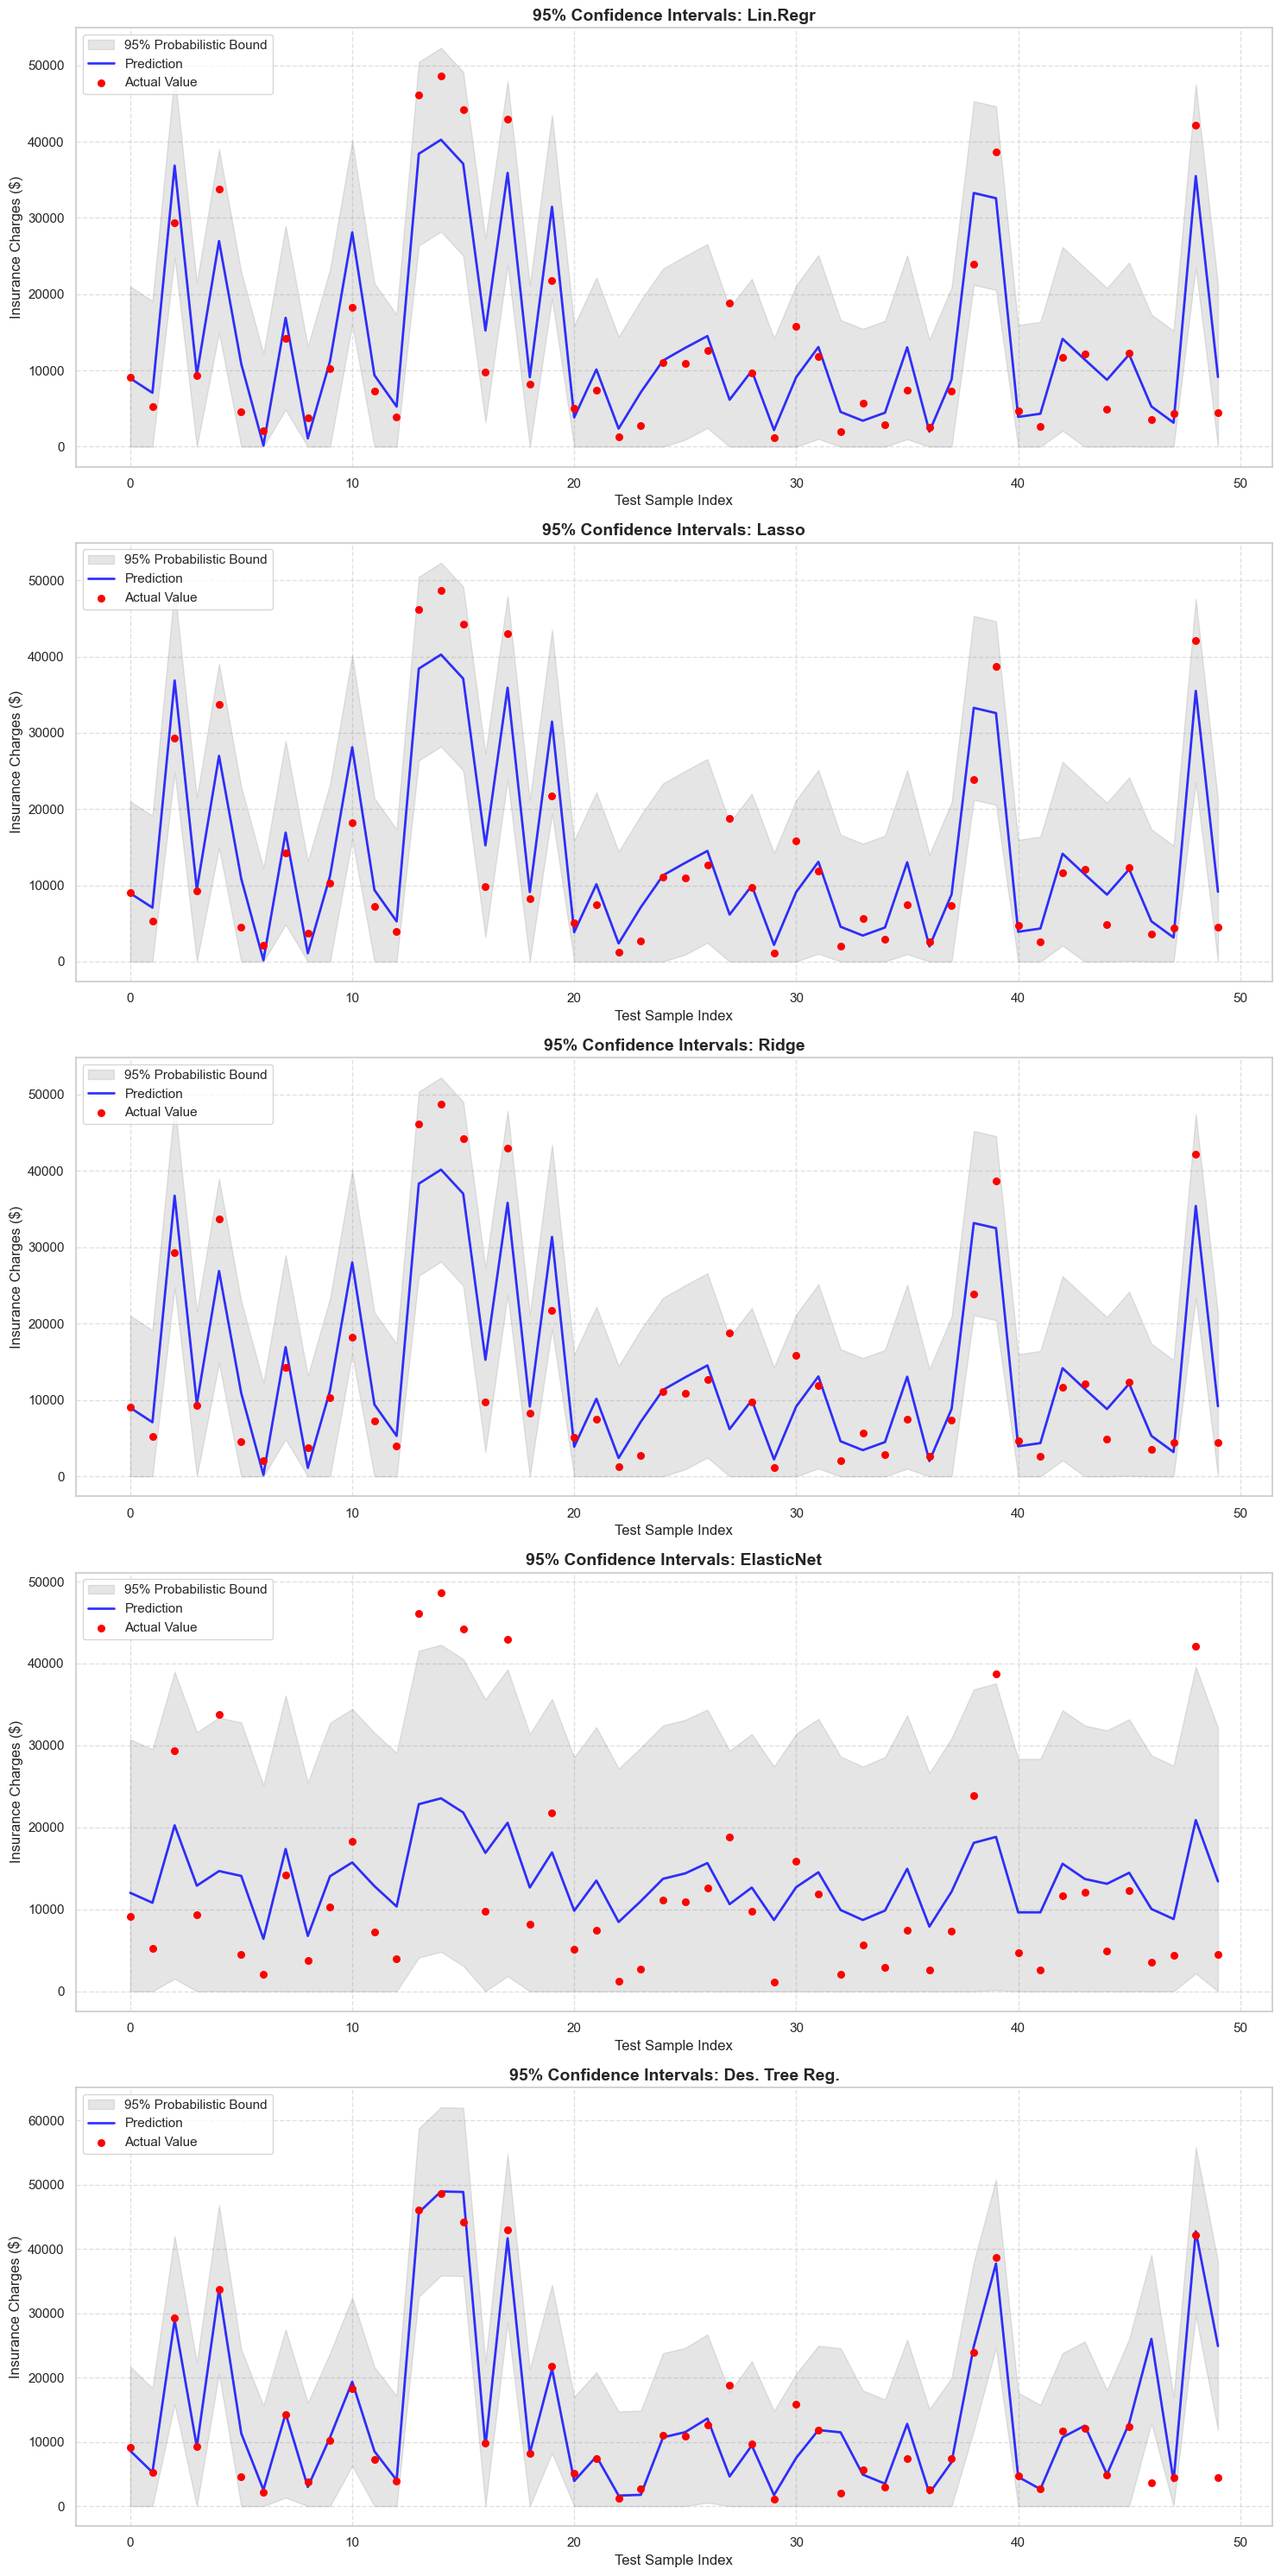

In [929]:
unique_models = final_preds_df["Model"].unique()
plot_model_intervals(final_preds_df, unique_models, n_samples=50)

From the image above we see some interesinting stuff: ElasticNet has wide confidence interval and low accuracy of prediction, while Decision Regressor Tree has narrow confidence interval and almost all values are predicted correctly.

Let's pick Decision Tree Regressor and tune it, and see how the results will change:

In [930]:
# save it now to be able to compare with tuned model
final_preds_df =  final_preds_df[final_preds_df["Model"] == "Des. Tree Reg."]
results_df = results_df[results_df["Model"] == "Des. Tree Reg."]

In [931]:
param_grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1, 5, 10],
    "criterion": ["squared_error", "friedman_mse"],
    "max_features": ["sqrt", None]
}
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error'
}
k = 5
tree = models[-1][1]

grid = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring=scoring,
    refit='R2', 
    n_jobs=-1,  
    verbose=1
)

grid.fit(X_train_transformed, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


,estimator,DecisionTreeR...ndom_state=42)
,param_grid,"{'criterion': ['squared_error', 'friedman_mse'], 'max_depth': [3, 5, ...], 'max_features': ['sqrt', None], 'min_samples_leaf': [1, 5, ...], ...}"
,scoring,"{'MAE': 'neg_mean_absolute_error', 'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}"
,n_jobs,-1
,refit,'R2'
,cv,None
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'squared_error'


In [932]:
print(f"Best R2: {grid.best_score_}")
print(f"Best Params: {grid.best_params_}")

Best R2: 0.8356879686154602
Best Params: {'criterion': 'squared_error', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


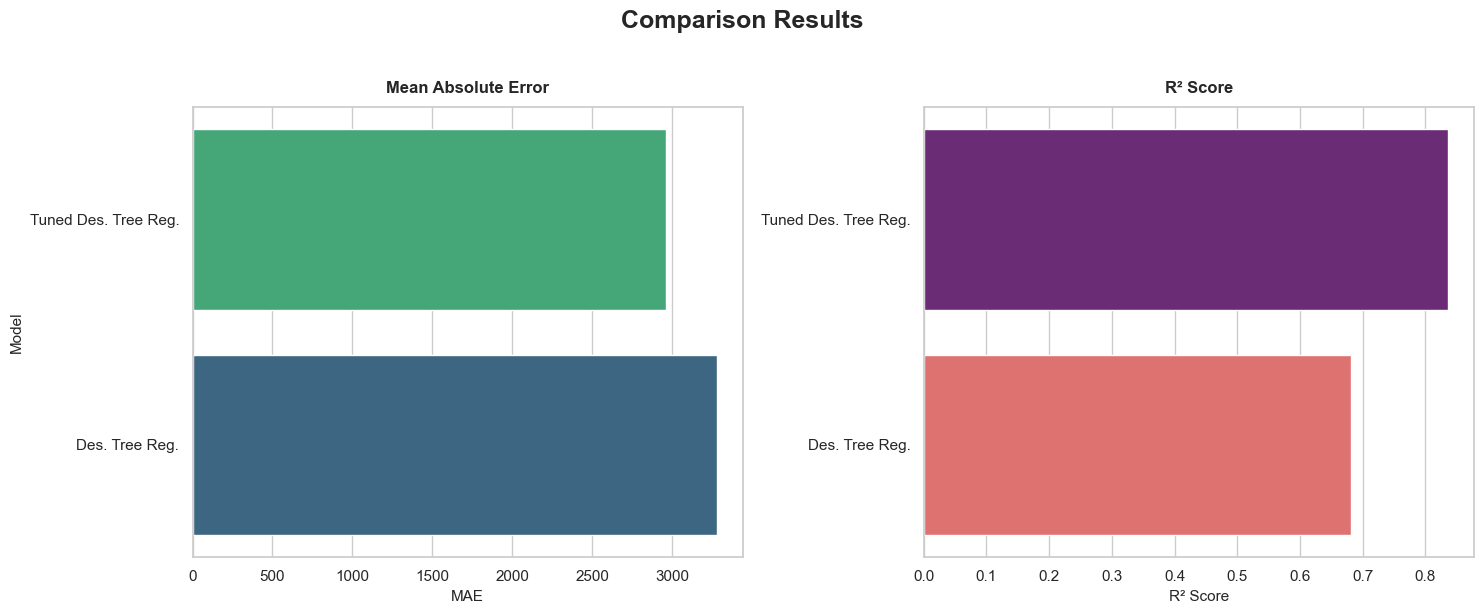

In [933]:
results = []

tuned_tree = grid.best_estimator_

y_hat = tuned_tree.predict(X_test_transformed)

results.append({
    "Model": "Tuned Des. Tree Reg.",
    "RMSE": abs(grid.cv_results_["mean_test_RMSE"][grid.best_index_]),
    "R2": grid.cv_results_["mean_test_R2"][grid.best_index_],
    "MAE": abs(grid.cv_results_["mean_test_MAE"][grid.best_index_]),
})

tuned_results_df = pd.DataFrame(results).sort_values(by="MAE")
final_results_df = pd.concat([tuned_results_df, results_df])

plot_regression_metrics(final_results_df, title="Comparison Results")

Since in hyperparameter tuning we was aimed to minimize R2 - we see the corresponding results, MAE is also decreased

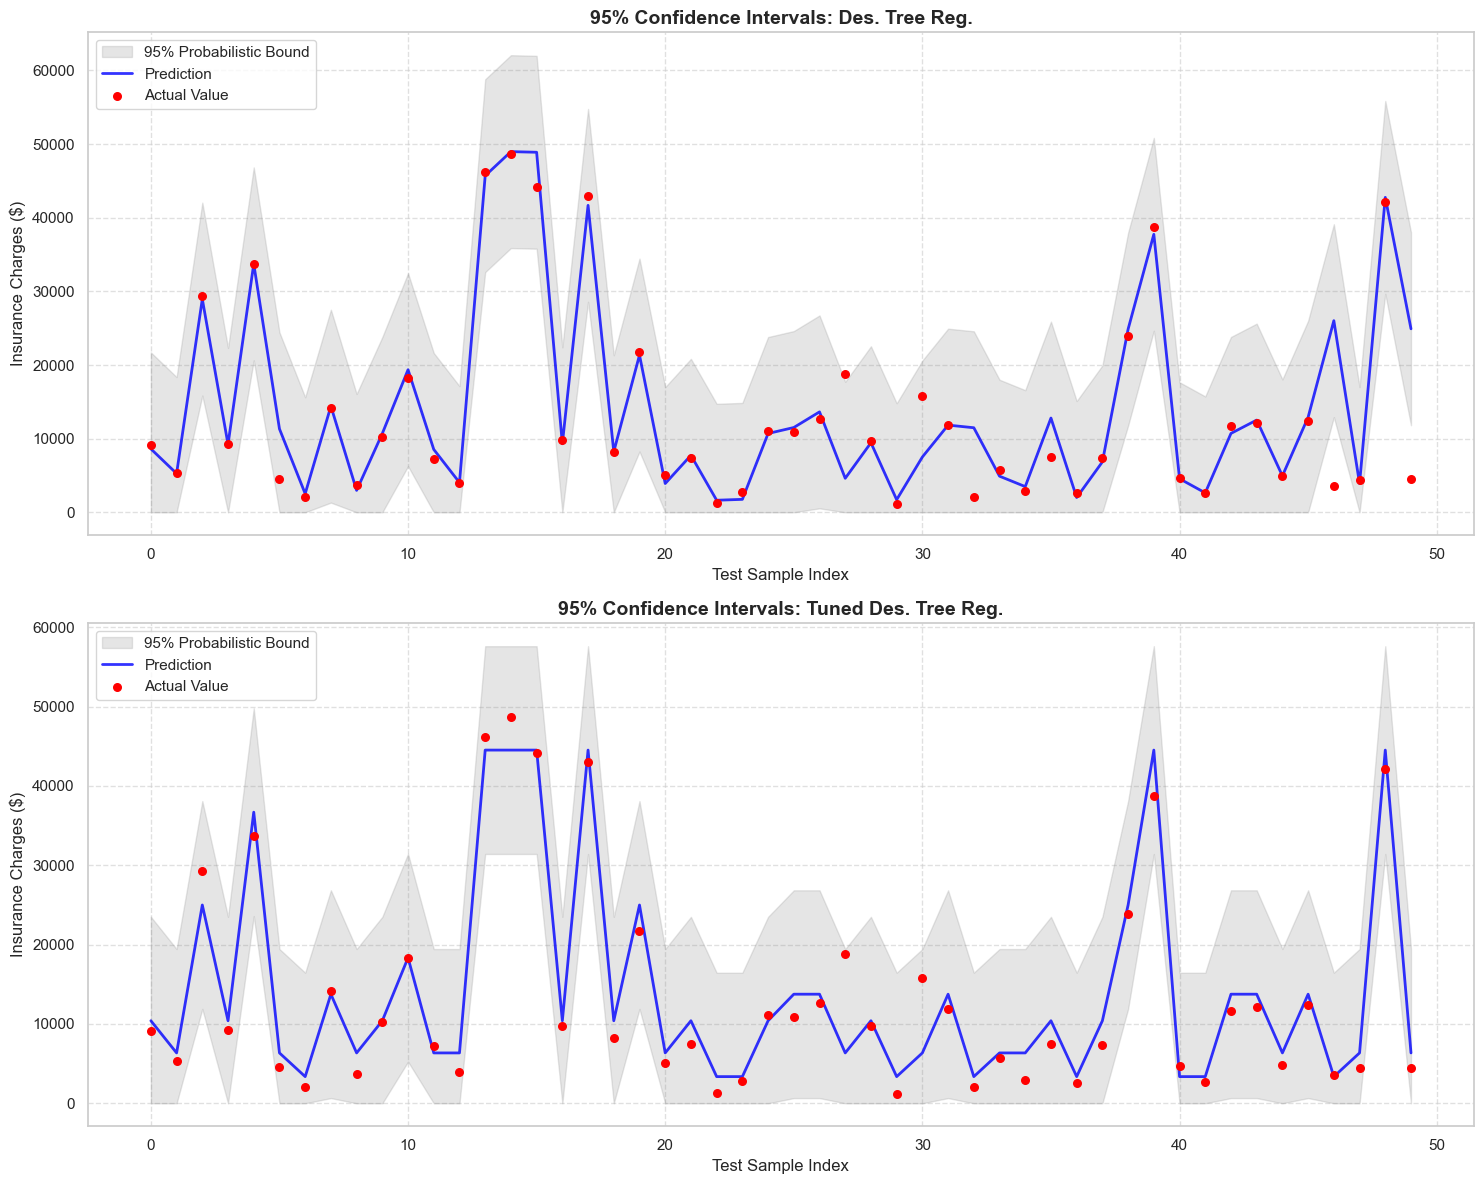

In [934]:
ci_plus, ci_minus = get_conf_int(y_hat, results_df["RMSE"].values[0])

tuned_final_preds_df = pd.concat([
    pd.DataFrame({
        'Actual': y_test.values,
        'Predicted': y_hat,
        'Lower_Bound': np.maximum(0, ci_minus), 
        'Upper_Bound': ci_plus,
        'Model': "Tuned Des. Tree Reg.",
    })
], ignore_index=True)

compare_preds_df = pd.concat([final_preds_df, tuned_final_preds_df])

unique_models = compare_preds_df["Model"].unique()
plot_model_intervals(compare_preds_df, unique_models, n_samples=50)

We see, that tuned model looks less overfitted and is aimed for generalization, not memorizing as untuned. This it the consequence of constraining params with grid search.

<a id="ensemble"></a>
### Ensemble Methods

Next, we will use ensemble methods to improve our results

In [935]:
stacking_base_estimators = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42))
]

ensemble_models = [
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42)),
    ("Bagging (KNN)", BaggingRegressor(estimator=KNeighborsRegressor(), n_estimators=50)),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ("XGBoost", XGBRegressor(n_estimators=100, random_state=42)),
    ("Stacking Regressor", StackingRegressor(estimators=stacking_base_estimators, final_estimator=Ridge()))
]



In [936]:
results_df = get_cv_regression_results(ensemble_models)

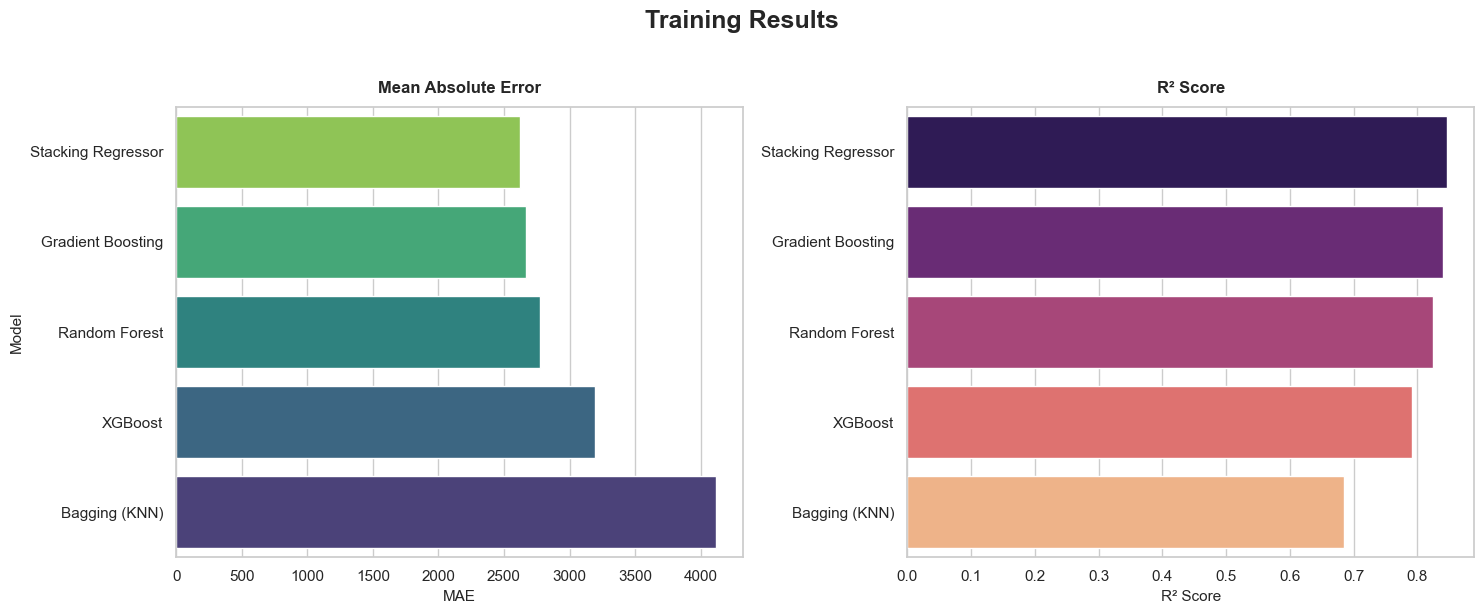

In [937]:
plot_regression_metrics(results_df, title="Training Results")

Here we see training results, and we see that, unsuprisingly, Stacking Regressor has showed the best results, but other models are also not bad fitted, except of Bagging(KNN)

In [938]:
trained_models = []

for name, model in ensemble_models:
    trained_models.append((
        name, model.fit(X_train_transformed, y_train)
    ))

In [939]:
ensemble_eval_results_df, final_preds_df = get_evaluation_results(trained_models, results_df)

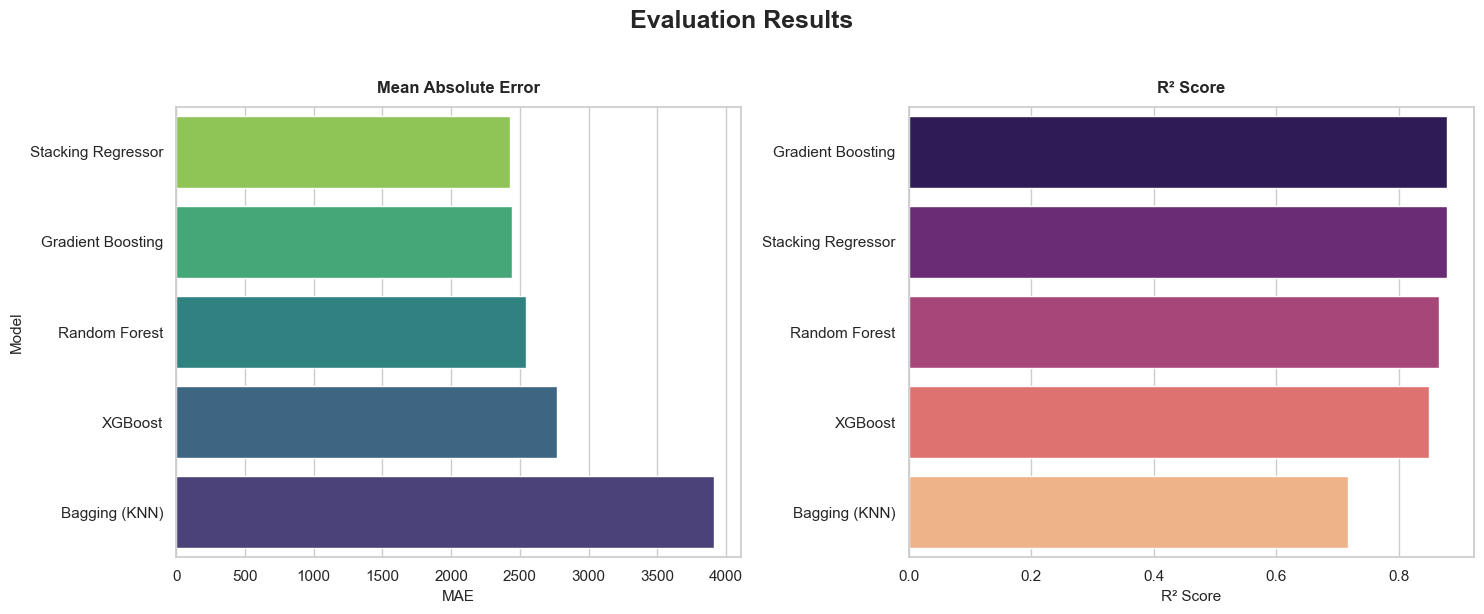

In [940]:
plot_regression_metrics(ensemble_eval_results_df, title="Evaluation Results")

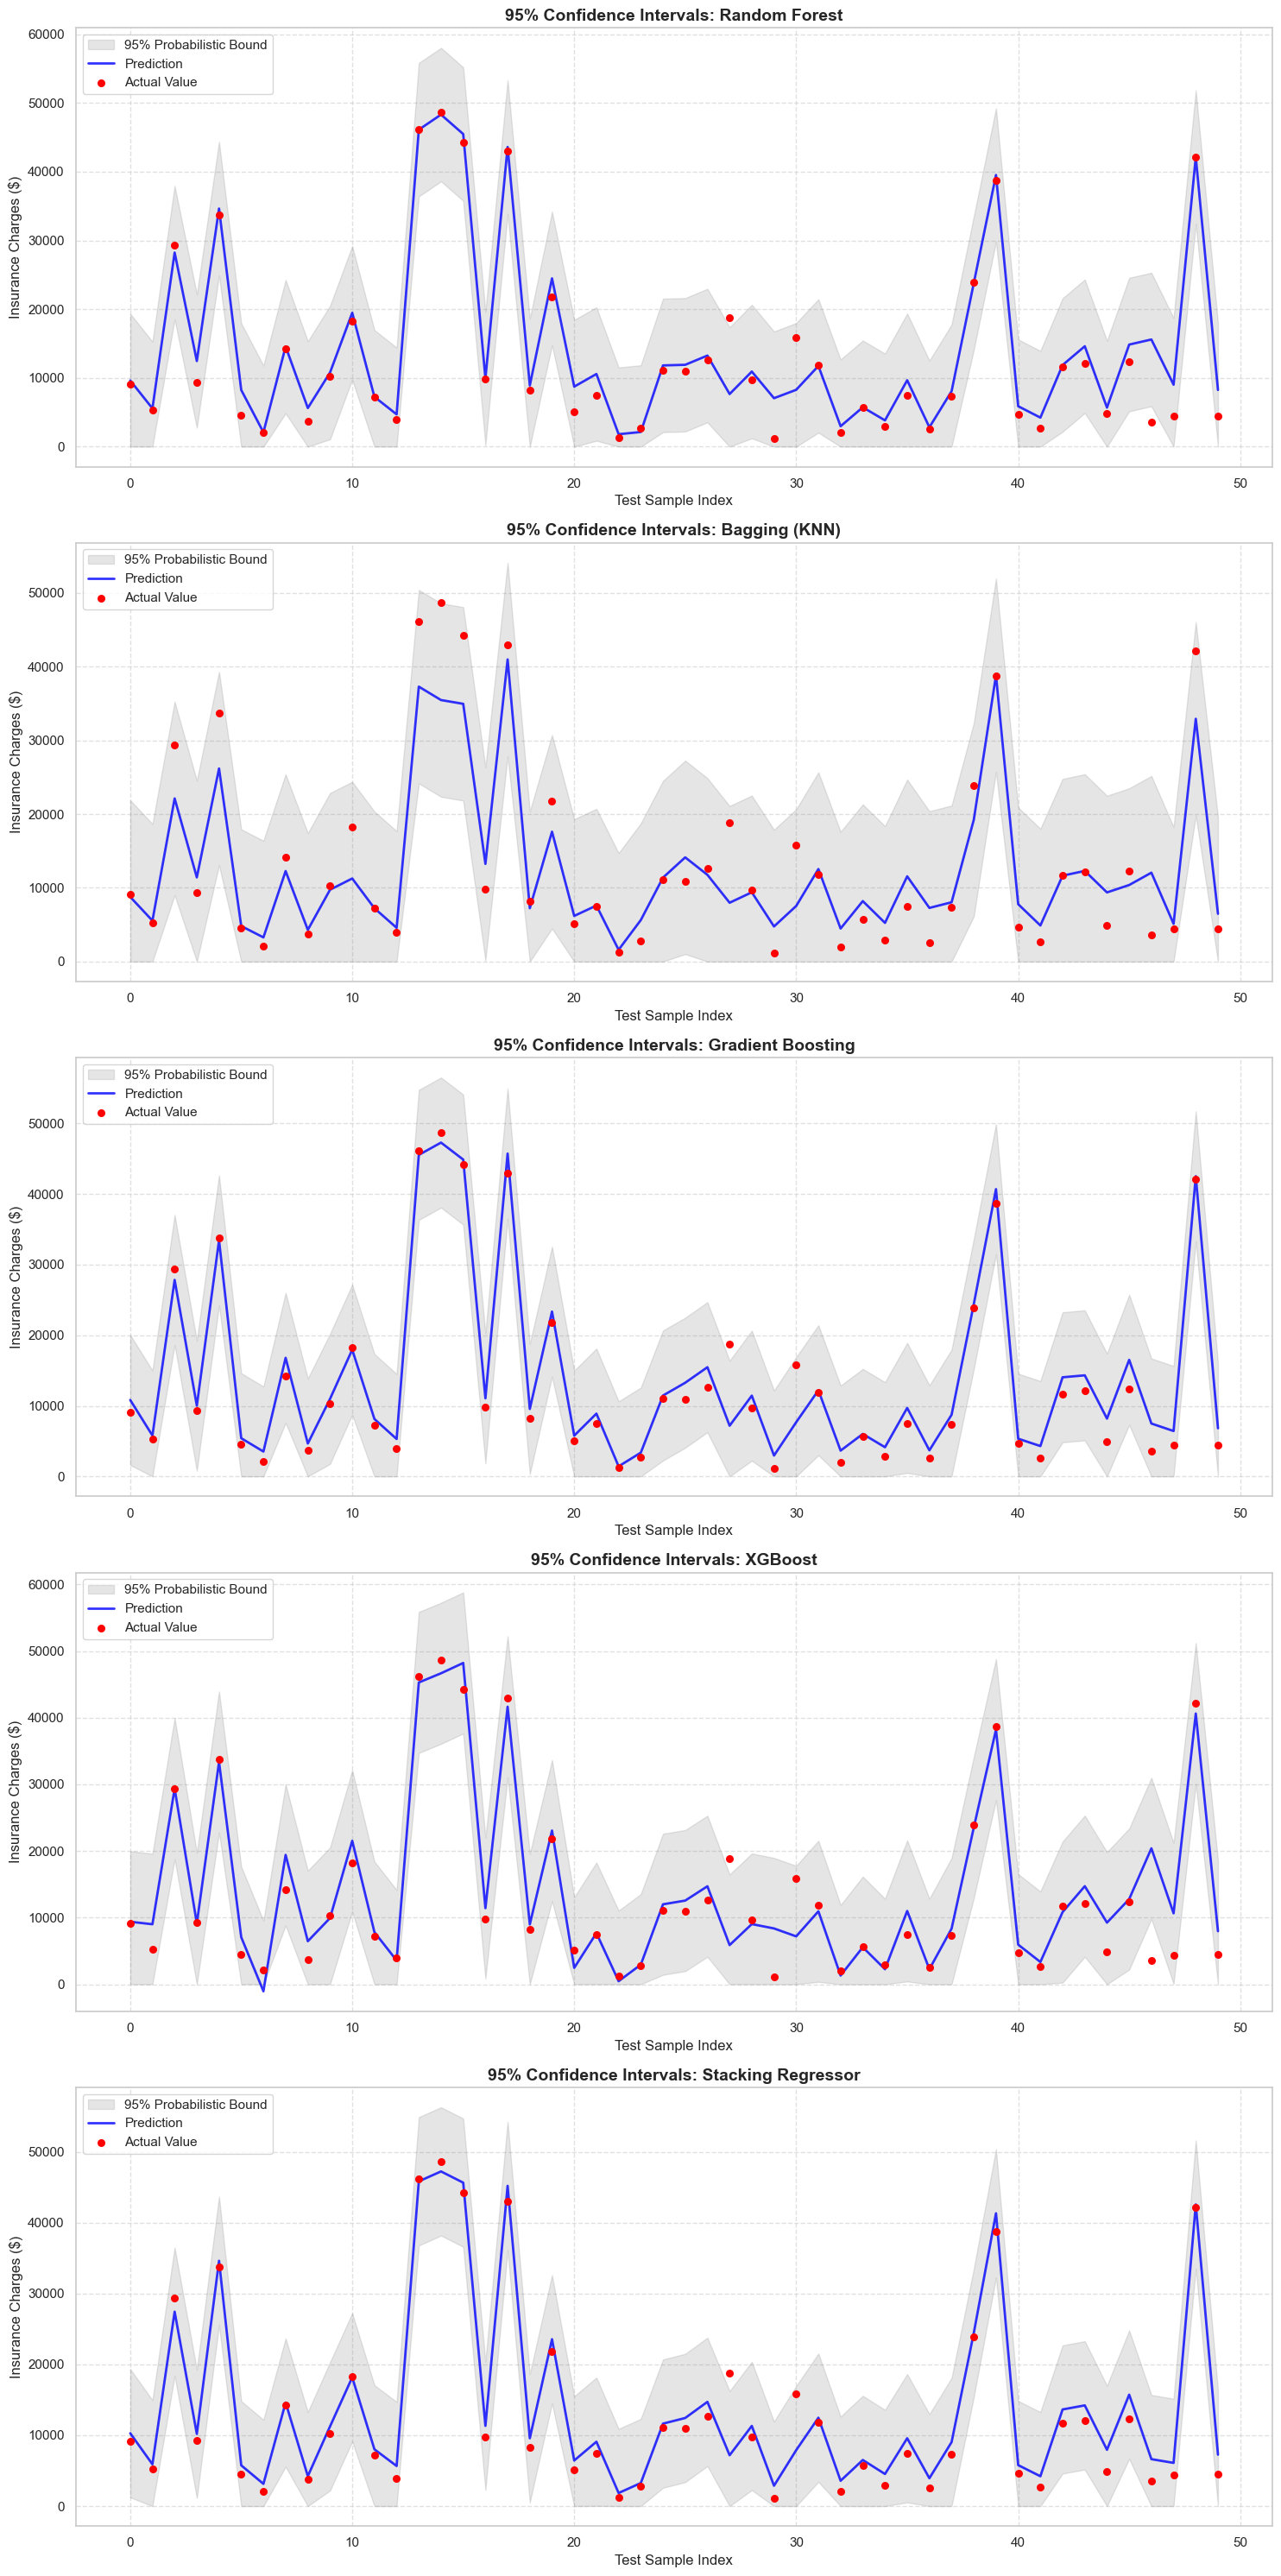

In [941]:
unique_models = final_preds_df["Model"].unique()
plot_model_intervals(final_preds_df, unique_models, n_samples=50)

Let's compare all test results of baseline models and ensemble in a one plot:

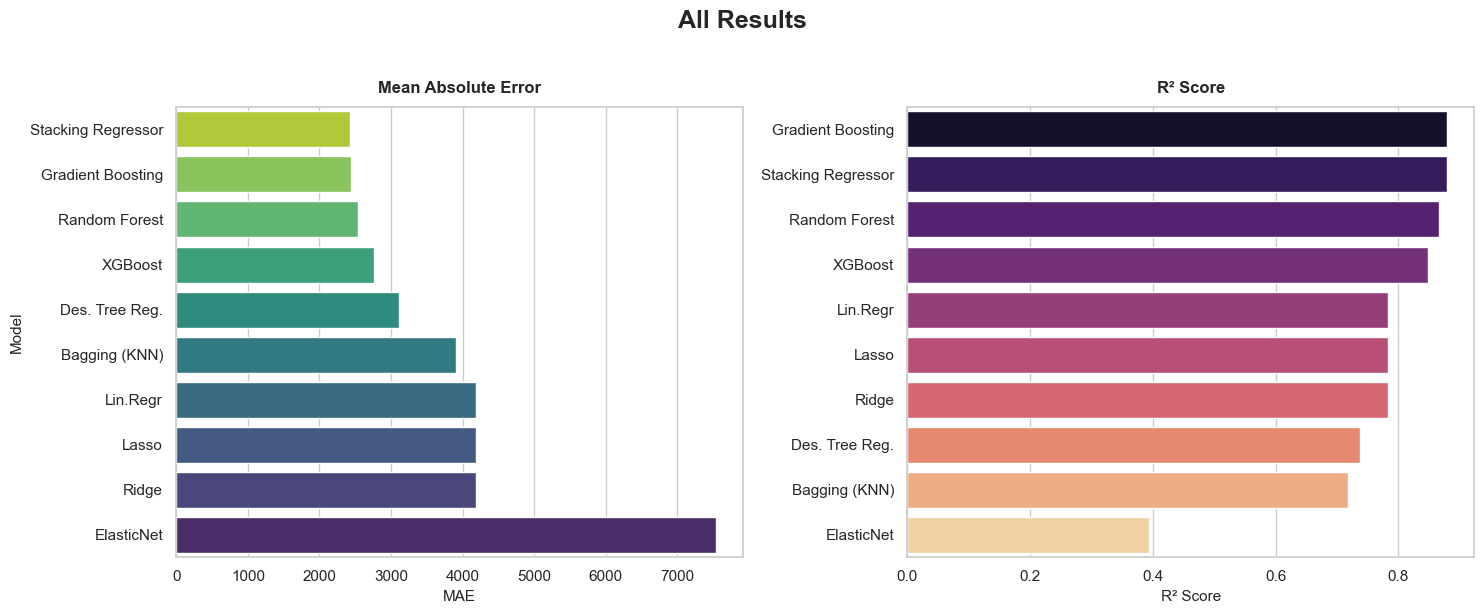

In [942]:
all_results_df = pd.concat([baseline_eval_results_df, ensemble_eval_results_df])

plot_regression_metrics(all_results_df, title="All Results")

As it was predicted - ensemble models have shown better results

Let's tune gradient boosting model and save, in order to compare later with best classfier model

In [1000]:
model = GradientBoostingRegressor(n_estimators=100, random_state=42)

param_grid = {
    'n_estimators': [100, 200],          
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]             
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=5,
    refit=True
)

grid.fit(X_train_transformed, y_train)

,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], 'n_estimators': [100, 200], 'subsample': [0.8, 1.0]}"
,scoring,'f1_weighted'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [1001]:
best_regression_model = grid.best_estimator_

best_model = grid.best_estimator_

filename = 'best_regression_model.pkl'

with open(filename, 'wb') as file:
    pickle.dump(best_model, file)
    
print(f"Model successfully saved as {filename}")

Model successfully saved as best_regression_model.pkl


<a id="discrete"></a>
### Discretization (Regression to Classification)

Now, let's move from regression problem to classification using discretization, to be more precise - equal-width method: 

In [943]:
le = LabelEncoder()

In [944]:
target = data["charges"]
n_classes = 5

target_discritized = pd.cut(target, bins=n_classes)

target_discritized.value_counts()

charges
(1059.225, 13651.585]     934
(13651.585, 26181.296]    215
(26181.296, 38711.006]     94
(38711.006, 51240.717]     89
(51240.717, 63770.428]      6
Name: count, dtype: int64

In [945]:
target_discritized = pd.Series(
    le.fit_transform(target_discritized), 
    index=target_discritized.index,  
    name=target_discritized.name     
)

target_discritized.value_counts()

charges
0    934
1    215
2     94
3     89
4      6
Name: count, dtype: int64

In [946]:
y_train_discritized = target_discritized.iloc[y_train.index]
y_test_discritized = target_discritized.iloc[y_test.index]

y_test_discritized

764     0
887     0
890     2
1293    0
259     2
       ..
109     3
575     0
535     0
543     4
846     0
Name: charges, Length: 268, dtype: int64

In [947]:
y_test

764      9095.06825
887      5272.17580
890     29330.98315
1293     9301.89355
259     33750.29180
           ...     
109     47055.53210
575     12222.89830
535      6067.12675
543     63770.42801
846      9872.70100
Name: charges, Length: 268, dtype: float64

And now, we can mvoe on to modeling

In [948]:
stacking_base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42))
]

classification_models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=5)),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("Support Vector Machine", SVC(probability=True, random_state=42)), 
    ("Neural Network (MLP)", MLPClassifier(max_iter=1000, random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("Bagging (KNN)", BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=5), n_estimators=50, random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("XGBoost", XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')),
    ("Stacking Classifier", StackingClassifier(estimators=stacking_base_estimators, final_estimator=LogisticRegression()))
]

In [949]:
import warnings
warnings.filterwarnings('ignore')

def get_cv_classification_results(models):
    scoring = {
        'Accuracy': 'accuracy',
        'Precision': make_scorer(precision_score, average='weighted', zero_division=0),
        'Recall': make_scorer(recall_score, average='weighted', zero_division=0),
        'F1': make_scorer(f1_score, average='weighted', zero_division=0)
}

    results = []
    k = 5

    for name, model in models:
        cv_results = cross_validate(
            estimator=model,
            X=X_train_transformed,
            y=y_train_discritized,
            cv=k,
            scoring=scoring
        )

        results.append({
        "Model": name,
        "Accuracy": cv_results['test_Accuracy'].mean(),
        "Precision": cv_results['test_Precision'].mean(),
        "Recall": cv_results['test_Recall'].mean(),
        "F1": cv_results['test_F1'].mean()
        })

        results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)

    return results_df

In [950]:
classification_results_df = get_cv_classification_results(classification_models)

In [951]:
def plot_classification_metrics(df, title="Classification Results"):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    palettes = ['viridis', 'magma', 'plasma', 'cividis']
    
    sns.set_theme(style="whitegrid")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten() 
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        df_sorted = df.sort_values(by=metric, ascending=False)
        
        sns.barplot(
            data=df_sorted, 
            x=metric, 
            y='Model', 
            hue='Model',       
            legend=False,      
            palette=palettes[i], 
            ax=ax
        )
        ax.set_title(f'{metric} Score', fontsize=14, fontweight='bold', pad=10)
        ax.set_xlabel(f'{metric} Score', fontsize=12)
        
        if i % 2 == 0:
            ax.set_ylabel('Model', fontsize=12)
        else:
            ax.set_ylabel('')
            
        max_val = df_sorted[metric].max()
        ax.axvline(x=max_val, color='grey', linestyle='--', linewidth=1.5, alpha=0.8, zorder=0)
        ax.text(max_val, -0.6, f' Best: {max_val:.4f} ', color='dimgrey', fontweight='bold', ha='center', va='bottom')

    fig.suptitle(title, fontsize=20, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()

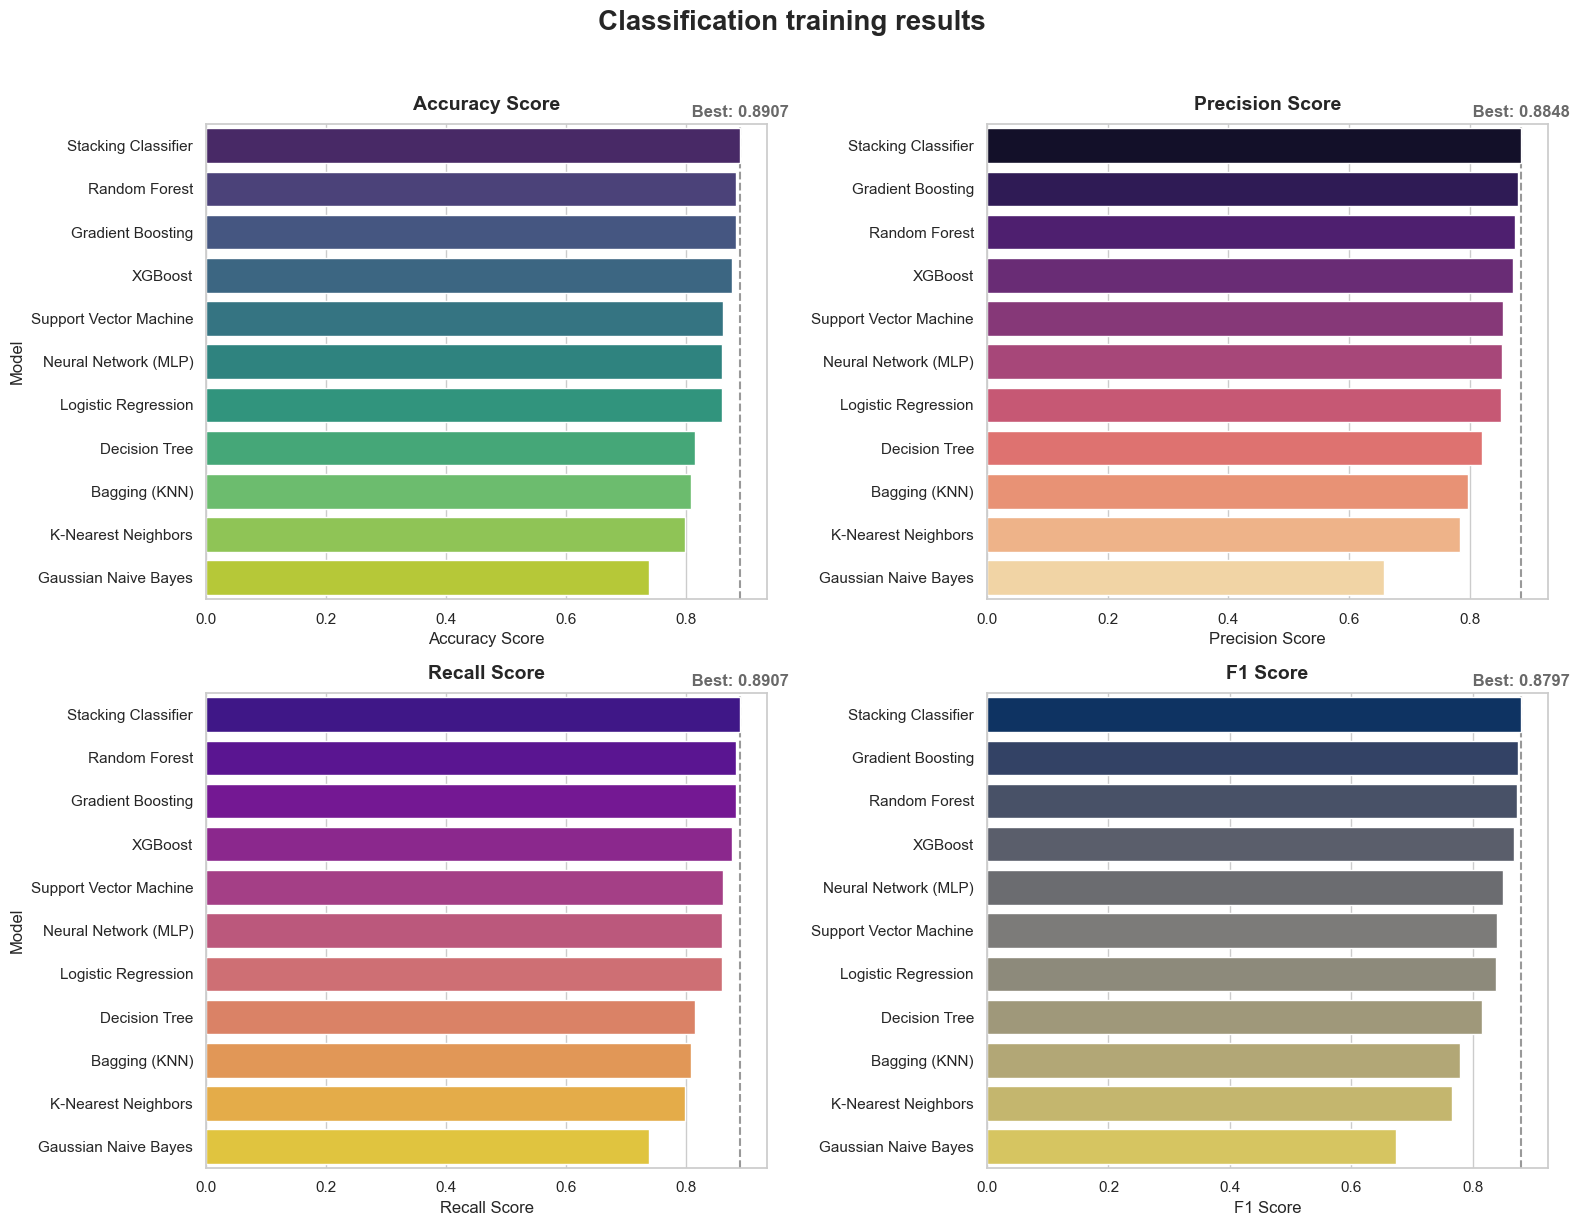

In [952]:
plot_classification_metrics(classification_results_df, title="Classification training results")

In [953]:
trained_models = []

for name, model in classification_models:
    trained_models.append((
        name, model.fit(X_train_transformed, y_train_discritized)
    ))

In [954]:
def get_evaluation_classification_results(trained_models):
    results = []

    for name, model in trained_models:
        y_hat = model.predict(X_test_transformed)

        results.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test_discritized, y_hat),
            "Precision": precision_score(y_test_discritized, y_hat, average='weighted', zero_division=0),
            "Recall": recall_score(y_test_discritized, y_hat, average='weighted', zero_division=0),
            "F1": f1_score(y_test_discritized, y_hat, average='weighted', zero_division=0)
        })

    results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)

    return results_df

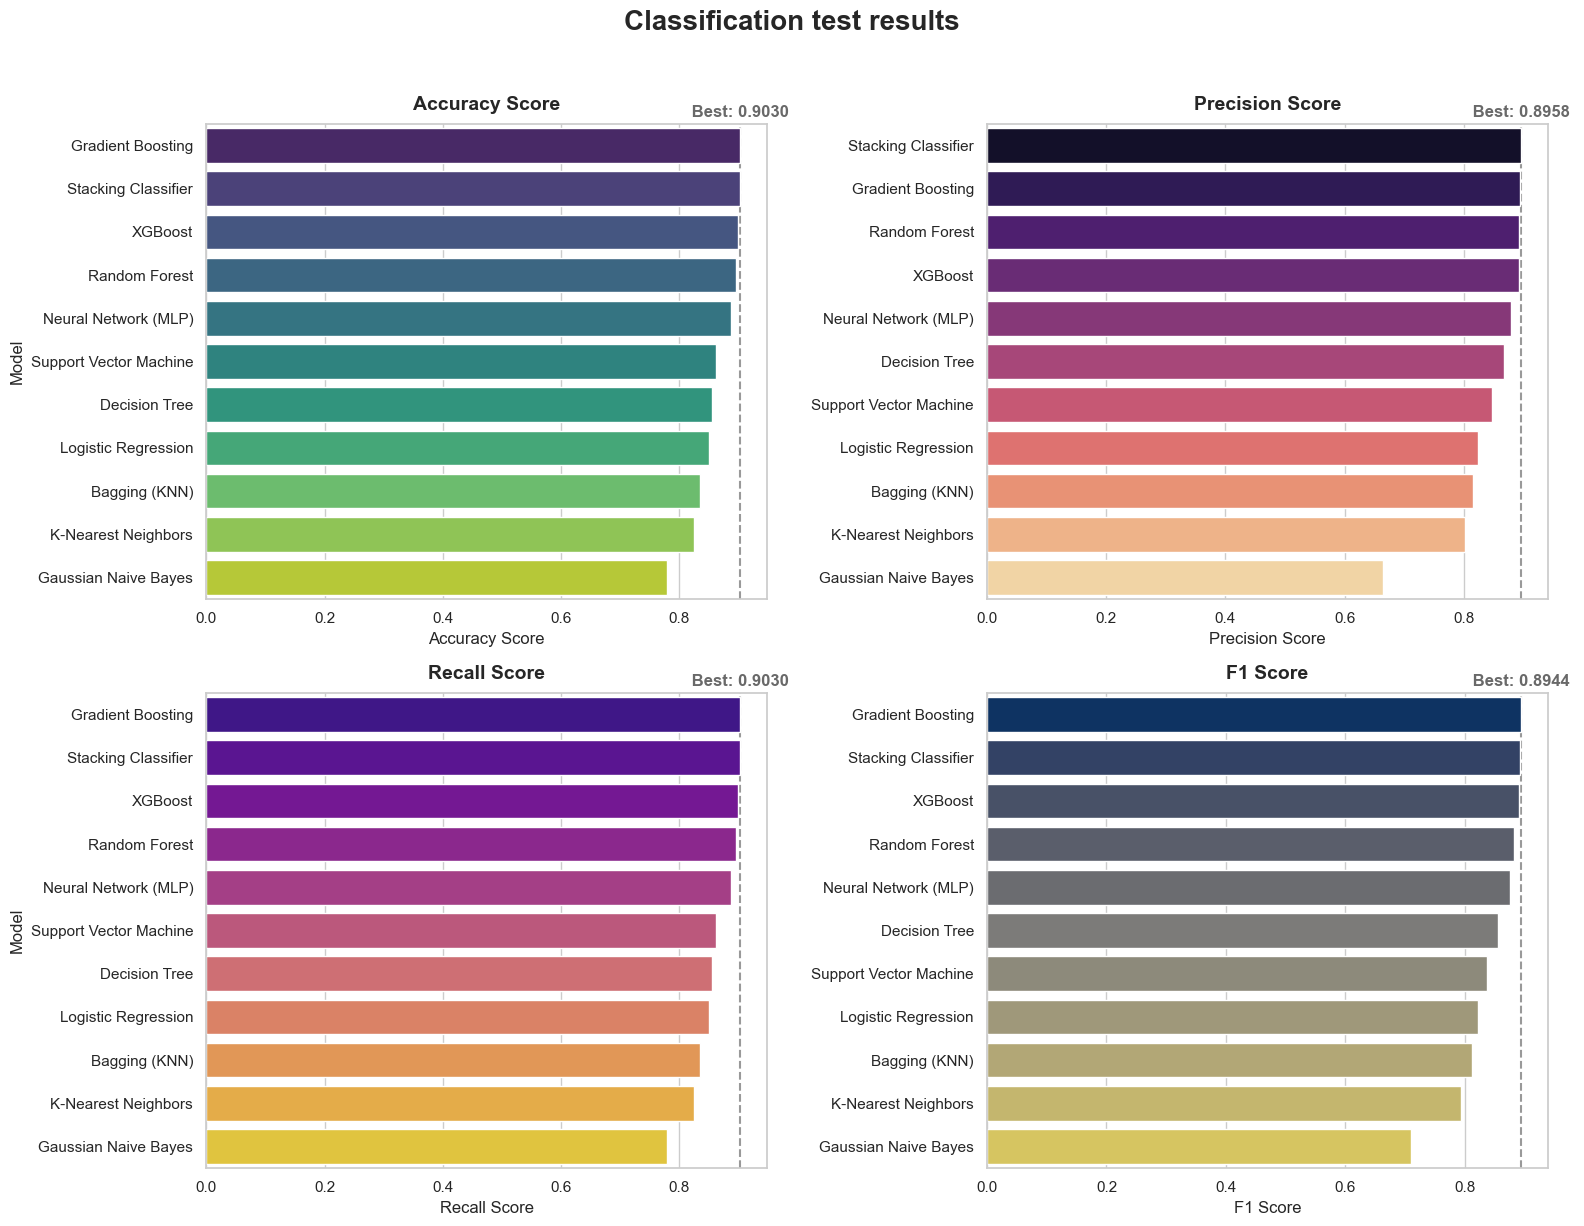

In [955]:
eval_classification_results_df = get_evaluation_classification_results(trained_models)
plot_classification_metrics(eval_classification_results_df, title="Classification test results")

Netx, i want to try different number of classes for classifcation, and we can achieve this by changing the step of discretization. Let's use Gradient Boosting as main model and f1-score as main metric to interpret by:

In [956]:
def discretize_target_variable(n_classes):
    le = LabelEncoder()
    target = data["charges"]

    target_discritized = pd.cut(target, bins=n_classes)

    target_discritized = pd.Series(
        le.fit_transform(target_discritized), 
        index=target_discritized.index,  
        name=target_discritized.name     
    )

    y_train_discritized = target_discritized.iloc[y_train.index]
    y_test_discritized = target_discritized.iloc[y_test.index]

    return y_train_discritized, y_test_discritized

In [957]:
f1_scores = []

for n_classes in range(2, 20):
    y_train_discritized, y_test_discritized = discretize_target_variable(n_classes)

    model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    y_hat = model.fit(X_train_transformed, y_train_discritized).predict(X_test_transformed)   

    f1 = f1_score(y_test_discritized, y_hat, average="weighted", zero_division=0)
    f1_scores.append({"n_classes": n_classes, "f1_score": f1})

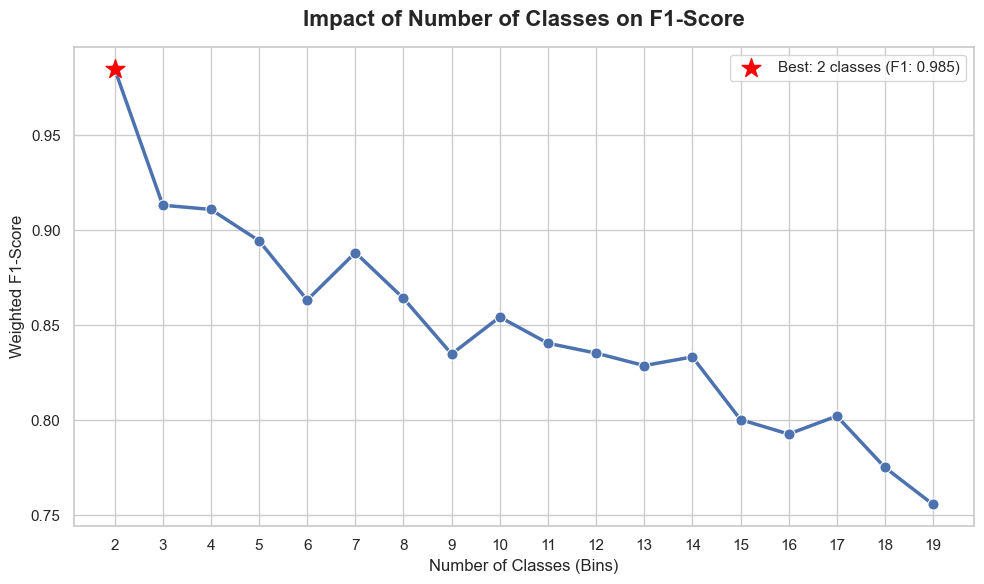

In [958]:
f1_df = pd.DataFrame(f1_scores)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=f1_df, 
    x="n_classes", 
    y="f1_score", 
    marker="o",        
    linewidth=2.5,     
    color="b", 
    markersize=8
)

best_row = f1_df.loc[f1_df['f1_score'].idxmax()]
best_n = int(best_row['n_classes'])
best_f1 = best_row['f1_score']

plt.scatter(best_n, best_f1, color='red', s=200, marker='*', zorder=5, label=f'Best: {best_n} classes (F1: {best_f1:.3f})')

plt.title("Impact of Number of Classes on F1-Score", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Number of Classes (Bins)", fontsize=12)
plt.ylabel("Weighted F1-Score", fontsize=12)

plt.xticks(range(2, 20)) 
plt.legend()
plt.tight_layout()

plt.show()

Here we see dependency of f1-score from number of classes, and we see interesting image: with bigger number of classes - the score is lower, and this is not surprising since it's bigger probability to classify sample having 2 classes than 20 or more

Let's also see at confusion matrix when n_classes = 4:

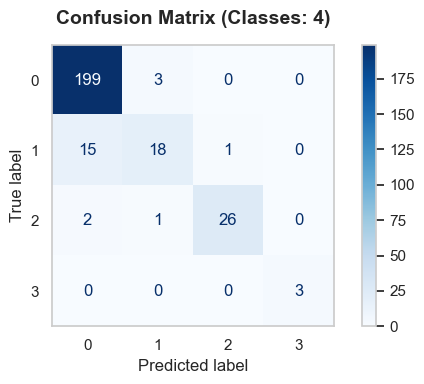

In [959]:
n_classes = 4

y_train_discritized, y_test_discritized = discretize_target_variable(n_classes)

model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train_transformed, y_train_discritized)
y_hat = model.predict(X_test_transformed)   

cm = confusion_matrix(y_test_discritized, y_hat)

plt.figure(figsize=(6, 4)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap='Blues', values_format='d', ax=plt.gca()) 

plt.title(f"Confusion Matrix (Classes: {n_classes})", fontsize=14, fontweight='bold', pad=15)
plt.grid(False) 
plt.tight_layout()
plt.show()

<a id="probs"></a>
### Probability Distributions & Confidence

Next, i want to show the probability distributions and confidence based on predictions of underfitted, ovrefitted and well-fitted models

In [960]:
under_model = LogisticRegression(C=0.0001, max_iter=1000, random_state=42)
under_model.fit(X_train_transformed, y_train_discritized)

over_model = DecisionTreeClassifier(max_depth=None, random_state=42)
over_model.fit(X_train_transformed, y_train_discritized)

good_model = model

models = [
    ("Underfitted", under_model),
    ("Overfitted", over_model),
    ("Good model", good_model),
]

In [961]:
traning_f1_score = []
test_f1_score = []
probabilities = []

for name, model in models:
    y_train_hat = model.predict(X_train_transformed)
    y_test_hat = model.predict(X_test_transformed)

    traning_f1_score.append((f"{name}", f1_score(y_train_discritized, y_train_hat, average="weighted")))
    test_f1_score.append((f"{name}", f1_score(y_test_discritized, y_test_hat, average="weighted")))
    probabilities.append((f"{name}", model.predict_proba(X_test_transformed)))

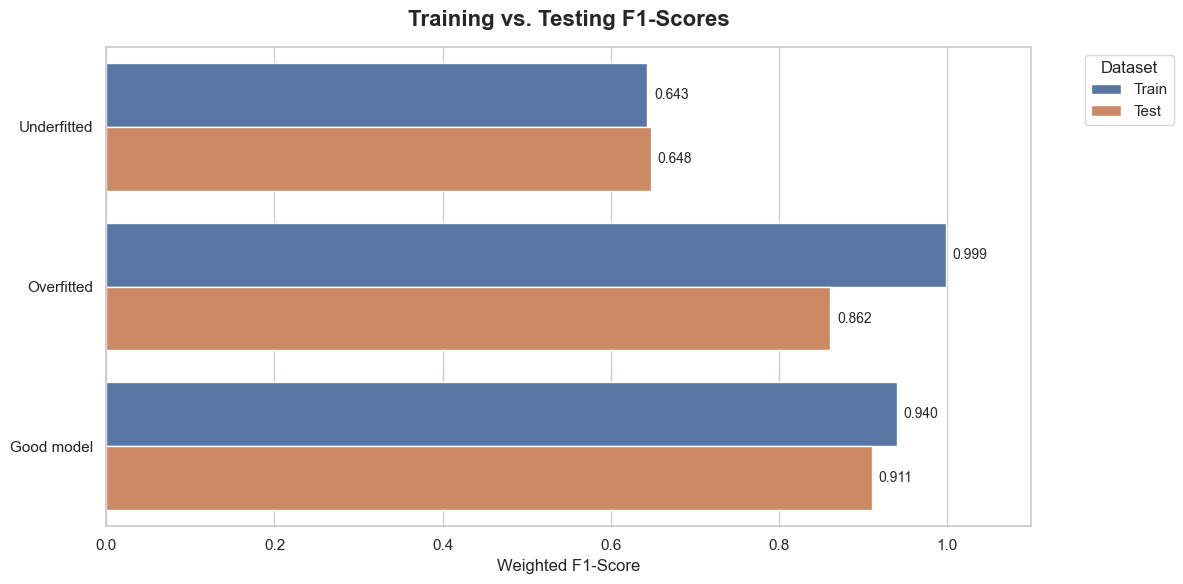

In [962]:
result_data = []
for (name, train_score), (_, test_score) in zip(traning_f1_score, test_f1_score):
    result_data.append({"Model": name, "F1-Score": train_score, "Dataset": "Train"})
    result_data.append({"Model": name, "F1-Score": test_score, "Dataset": "Test"})

df_scores = pd.DataFrame(result_data)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, max(6, len(models) * 0.8))) 

ax = sns.barplot(
    data=df_scores,
    x="F1-Score",
    y="Model",
    hue="Dataset",
    palette=["#4C72B0", "#DD8452"] 
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=5, fontsize=10)

plt.title("Training vs. Testing F1-Scores", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Weighted F1-Score", fontsize=12)
plt.ylabel("") 
plt.xlim(0, 1.1) 

plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

From the image above we see, that we create approximately we have created underfitted, overfitted and good model, next i want to see the probability distributions for each class, how model is confident about it's predictions

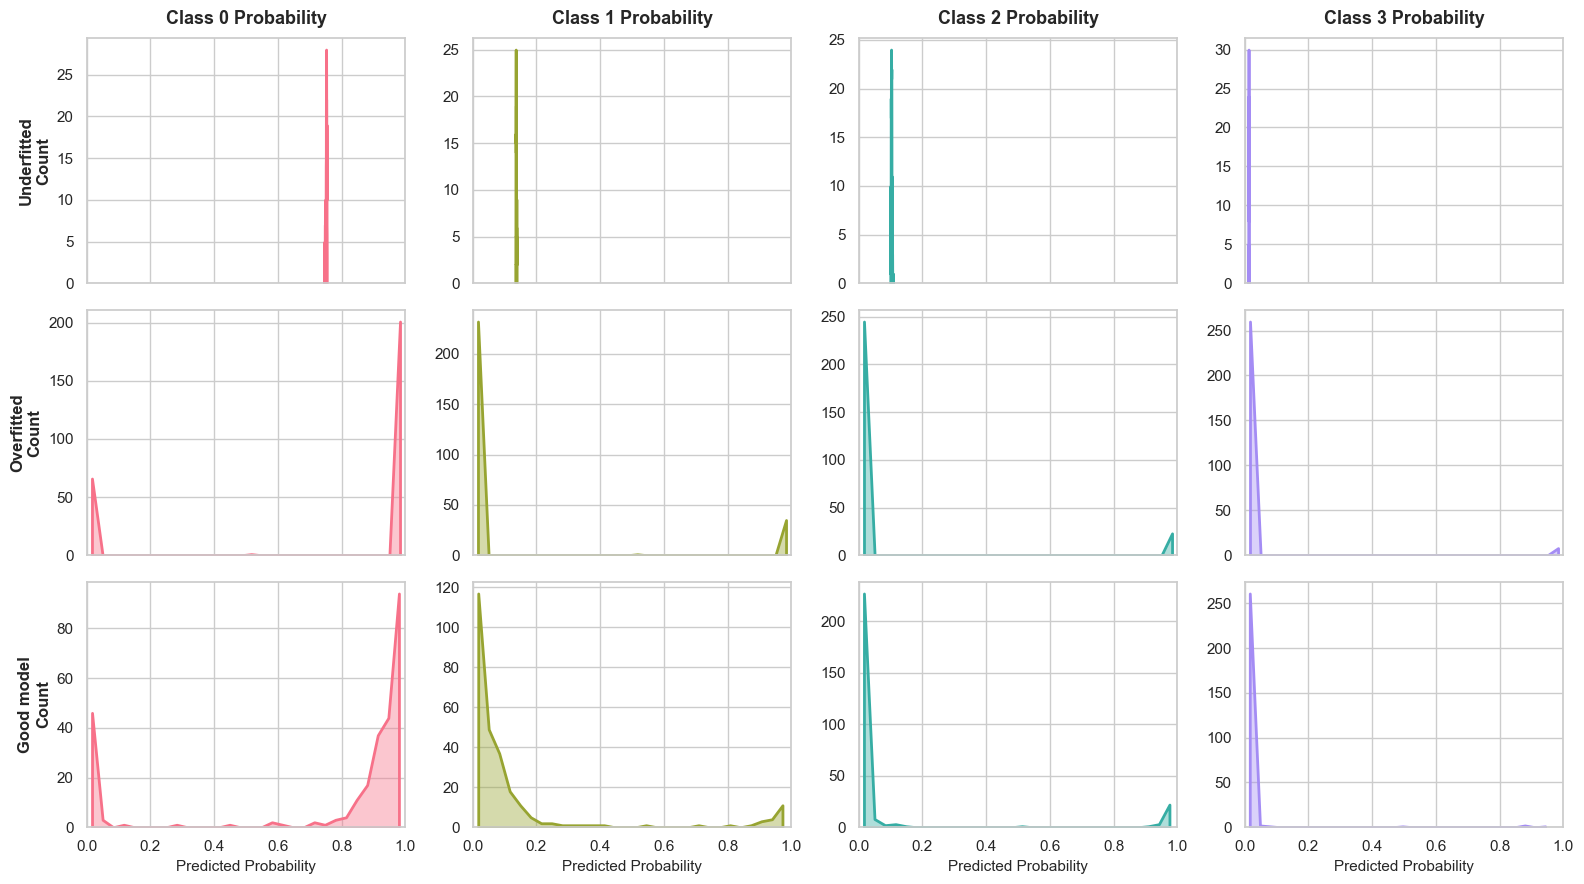

In [963]:
n_models = len(probabilities)
n_classes = probabilities[0][1].shape[1] 

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(
    nrows=n_models, 
    ncols=n_classes, 
    figsize=(4 * n_classes, 3 * n_models), 
    sharex=True,
    squeeze=False 
)

colors = sns.color_palette("husl", n_classes)

for model_idx, (name, pred_proba) in enumerate(probabilities):
    for class_idx in range(n_classes):
        ax = axes[model_idx, class_idx]
        
        sns.histplot(
            pred_proba[:, class_idx], 
            ax=ax, 
            color=colors[class_idx],
            element="poly",    
            fill=True,         
            stat="count",      
            bins=30,           
            linewidth=2,
            alpha=0.4
        )

        ax.set_xlim(0, 1.0)
        
        if class_idx == 0:
            ax.set_ylabel(f'{name}\nCount', fontsize=12, fontweight='bold')
        else:
            ax.set_ylabel('')
            
        if model_idx == 0:
            ax.set_title(f'Class {class_idx} Probability', fontsize=13, fontweight='bold', pad=10)
            
        if model_idx == n_models - 1:
            ax.set_xlabel('Predicted Probability', fontsize=11)
        else:
            ax.set_xlabel('')



plt.tight_layout()
plt.show()

In [964]:
y_train_discritized.value_counts()

charges
0    803
1    145
2    109
3     13
Name: count, dtype: int64

In [965]:
y_test_discritized.value_counts()

charges
0    202
1     34
2     29
3      3
Name: count, dtype: int64

**1. The Underfitted Model**

Looking at the underfitted model (like the highly penalized Logistic Regression), it’s clear the model completely failed to learn any of the actual medical features. Instead of diagnosing patients, it just looked at the class imbalance in our training set and defaulted to guessing those exact averages. We started with 1070 training samples, and if we calculate the raw distribution (Class 0: 75.0%, Class 1: 13.5%, Class 2: 10.1%, Class 3: 1.2%), we can see vertical spikes in the histogram hitting those exact probability marks. It’s basically ignoring the patients' symptoms and assigning the dataset's baseline probability to everyone.

**2. The Overfitted Model**

The overfitted model, like the unpruned Decision Tree, went in the complete opposite direction and just memorized the training data. You can see this in the graph because there is absolutely zero probability density in the middle—the predictions are violently forced into either 0% or 100% certainty. In real-world medical data, symptoms overlap and cases are naturally ambiguous. A model that acts this arrogant and refuses to show any uncertainty is dangerously inflexible, meaning we definitely can't trust it to evaluate new, unseen patients.

**3. The Well-Tuned Model**

Finally, the optimized ensemble shows what a reliable diagnostic AI should actually look like. Instead of rigid spikes, we get smooth, dynamic probability curves. The model still has distinct peaks near the extremes, meaning it confidently flags the obvious, textbook cases. But crucially, we can see density stretching across the middle ranges. This shows the model actually understands medical nuance—it has learned the real patterns and actively scales back its certainty when it encounters a difficult, borderline edge-case.

<a id="opt"></a>
### Optimization via GridSearchCV

Let's tune best classifier model for this dataset, with n_classes = 2:

In [986]:
n_classes = 2

y_train_discritized, y_test_discritized = discretize_target_variable(n_classes)

model = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [987]:
param_grid = {
    'n_estimators': [100, 200],          
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]             
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=5,
    refit=True,
    n_jobs=-1
)

grid.fit(X_train_transformed, y_train_discritized)

,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], 'n_estimators': [100, 200], 'subsample': [0.8, 1.0]}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'log_loss'


In [992]:
best_classifier_model = grid.best_estimator_

filename = 'best_classification_model.pkl'

with open(filename, 'wb') as file:
    pickle.dump(best_model, file)
    
print(f"Model successfully saved as {filename}")

Model successfully saved as best_classification_model.pkl


<a id="metrics"></a>
### Metric Bridging & Final Conversion

In [994]:
best_classifier_model

,loss,'log_loss'
,learning_rate,0.01
,n_estimators,100
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [995]:
best_regression_model

,loss,'squared_error'
,learning_rate,0.001
,n_estimators,50
,subsample,0.7
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [998]:
y_hat_class = best_classifier_model.predict(X_test_transformed)

classification_scores = pd.DataFrame([{
    "Accuracy": accuracy_score(y_test_discritized, y_hat_class),
    "F1_Score": f1_score(y_test_discritized, y_hat_class, average="weighted", zero_division=0),
    "Precision": precision_score(y_test_discritized, y_hat_class, average="weighted", zero_division=0),
    "Recall": recall_score(y_test_discritized, y_hat_class, average="weighted", zero_division=0)
}], index=["Best Tuned Classifier"])

classification_scores

,Accuracy,F1_Score,Precision,Recall
Best Tuned Classifier,0.985075,0.984865,0.98492,0.985075


In [1002]:
y_hat_reg = best_regression_model.predict(X_test_transformed)

regression_scores = pd.DataFrame([{
    "MAE": mean_absolute_error(y_test, y_hat_reg),
    "MSE": mean_squared_error(y_test, y_hat_reg),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_hat_reg)),
    "R2_Score": r2_score(y_test, y_hat_reg)
}], index=["Best Tuned Regressor"])

regression_scores

,MAE,MSE,RMSE,R2_Score
Best Tuned Regressor,4782.684799,3.871506e+07,6222.142739,0.750626


And now, what i want to do? I want with the help of the following formulas transform MAE into accuracy, and reverse.
First Formula (Accuracy Approximation):
$$accuracy \approx 1 - \frac{MAE}{w}$$
, where w is the bin width (or class interval bin)

In [1005]:
max_y = data["charges"].max()
min_y = data["charges"].min()

max_y, min_y

(63770.42801, 1121.8739)

In [1006]:
w = (max_y - min_y) / n_classes
w

31324.277055000002

In [1010]:
accuracy_hat = 1 - (regression_scores["MAE"].values[0] / w)
accuracy_hat

0.8473169934351804

Original accuracy, got on classification testing, is 0.985, and our prediction based on MAE is 0.847. This error in computing can be epxlained: in regression we care about actual exact number, while in classifiaction we don't care about how we compute prediction, how accurate it, because if we guess the exact class - we are right, so  accuracy got from MAE can be smaller that actual because regression task is aimed for precision.

Second Formula (MAE Approximation):
$$MAE \approx (1 - Accuracy) \times R + \frac{w}{2}$$
, where R is the range of target variable (Max value - Min value) and w is the width of the bin(class interval)

In [ ]:
R = max_y - min_y
w = R / n_classes

MAE_predicted = ((1 - classification_scores["Accuracy"].values[0]) * R) + (w/2)
MAE_predicted

16597.191573917913

Our predicted MAE is 16597.189, while actual is 4782.684799. This can be explained by the nature of data - it is not perfectly distributed as assumed by the formula

Next, we will discretize the continuous predictions generated by the regression model and compare them to the true class labels to calculate the classification accuracy. Following this, we will perform the reverse evaluation on the classifier model: we will transform its discrete predictions into continuous values by mapping each predicted class to its actual mean, and then evaluate these results against the true test samples using Mean Absolute Error (MAE).

In [1016]:
discretizer = KBinsDiscretizer(n_bins=n_classes, encode='ordinal', strategy='uniform')

discretizer.fit(y_test.values.reshape(-1, 1))

y_hat_reg_classes = discretizer.transform(y_hat_reg.reshape(-1, 1))

actual_reg_accuracy = accuracy_score(y_test_discritized, y_hat_reg_classes)
actual_class_accuracy = accuracy_score(y_test_discritized, y_hat_class)

print(f"Discretized Accuracy: {actual_reg_accuracy:.4f}")
print(f"Actual Accuracy: {actual_class_accuracy:.4f}")

Discretized Accuracy: 0.9254
Actual Accuracy: 0.9851


In [1026]:
first_class_mean =  y_train[y_train < (((max_y - min_y) / n_classes) + min_y)].mean()
second_class_mean =  y_train[y_train >= (((max_y - min_y) / n_classes) + min_y)].mean()

first_class_mean, second_class_mean

(9754.611716867088, 41253.64024852459)

In [1027]:
y_hat_class_reg = [first_class_mean if class_pred == 0 else second_class_mean for class_pred in y_hat_class]


actual_reg_MAE = mean_absolute_error(y_test, y_hat_reg)
actual_class_MAE = mean_absolute_error(y_test, y_hat_class_reg)


print(f"Actual MAE: {actual_reg_MAE:.4f}")
print(f"Predicted MAE from classes: {actual_class_MAE:.4f}")

Actual MAE: 4782.6848
Predicted MAE from classes: 5646.8380
